In [196]:
import pickle
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [197]:
EMBEDDING_DIM = 50
MAX_LENGTH = 32
TRAINING_SPLIT = 0.9
NUM_BATCHES = 128

In [198]:
data_path = "./machineLearning_Dataset.csv"
df = pd.read_csv(data_path)
df.head()

,description,category
0,Coffee,Food
1,Groceries at Walmart,Food
2,Gasoline at Shell,Transportation
3,Dinner at Olive Garden,Food
4,Movie tickets,Entertainment


In [199]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['description'])

In [200]:
def augment_text(text):
    tokens = text.split()
    if len(tokens) > 1:
        tf.random.shuffle(tokens)
    return ' '.join(tokens)

In [201]:
augmented_texts = []
for text in df['description']:
    augmented_texts.append(augment_text(text))

In [202]:
augmented_data = pd.DataFrame({
    'description': list(df['description']) + augmented_texts,
    'category': list(df['category']) * 2
})

In [203]:
augmented_data = shuffle(augmented_data).reset_index(drop=True)
data = augmented_data

In [204]:
print(data)

              description         category
0            satellite TV          Housing
1        Composition book  School Supplies
2                   Boots    Miscellaneous
3                  wrench          Housing
4                lighters          Housing
...                   ...              ...
3189    Supercuts Haircut    Personal Care
3190              Printer       Technology
3191           Car repair   Transportation
3192               Laptop       Technology
3193  External hard drive       Technology

[3194 rows x 2 columns]


In [205]:
label_encoder = LabelEncoder()

data['Label_Encoded'] = label_encoder.fit_transform(data['category'])

print(data)

              description         category  Label_Encoded
0            satellite TV          Housing              3
1        Composition book  School Supplies              7
2                   Boots    Miscellaneous              4
3                  wrench          Housing              3
4                lighters          Housing              3
...                   ...              ...            ...
3189    Supercuts Haircut    Personal Care              6
3190              Printer       Technology              8
3191           Car repair   Transportation              9
3192               Laptop       Technology              8
3193  External hard drive       Technology              8

[3194 rows x 3 columns]


In [206]:
labels = data['Label_Encoded'].to_numpy()
sentences = data['description'].to_numpy()

# Create the dataset
dataset = tf.data.Dataset.from_tensor_slices((sentences, labels))

# Get the first 5 elements of the dataset
examples = list(dataset.take(5))

print(f"dataset contains {len(dataset)} examples\n")

print(f"Text of second example look like this: {examples[1][0].numpy().decode('utf-8')}\n")
print(f"Labels of first 5 examples look like this: {[x[1].numpy() for x in examples]}")

dataset contains 3194 examples

Text of second example look like this: Composition book

Labels of first 5 examples look like this: [3, 7, 4, 3, 3]


In [207]:
def train_val_datasets(dataset):
    train_size = int(len(dataset) * TRAINING_SPLIT)

    # Split the sentences and labels into train/validation splits
    train_dataset = dataset.take(train_size)
    validation_dataset = dataset.skip(train_size)

    # Turn the dataset into a batched dataset with num_batches batches
    train_dataset = train_dataset.batch(NUM_BATCHES)
    validation_dataset = validation_dataset.batch(NUM_BATCHES)

    return train_dataset, validation_dataset

In [208]:
# Create the train and validation datasets
train_dataset, validation_dataset = train_val_datasets(dataset)

print(f"There are {len(train_dataset)} batches for a total of {NUM_BATCHES*len(train_dataset)} elements for training.\n")
print(f"There are {len(validation_dataset)} batches for a total of {NUM_BATCHES*len(validation_dataset)} elements for validation.\n")

There are 23 batches for a total of 2944 elements for training.

There are 3 batches for a total of 384 elements for validation.



In [209]:
def fit_vectorizer(dataset):
    vectorizer = tf.keras.layers.TextVectorization(
        output_sequence_length=MAX_LENGTH,  # Desired length of output sequences
    )

    # Fit the tokenizer to the training sentences
    vectorizer.adapt(dataset)

    return vectorizer

In [210]:
# Get only the texts out of the dataset
text_only_dataset = train_dataset.map(lambda text, label: text)

# Adapt the vectorizer to the training sentences
vectorizer = fit_vectorizer(text_only_dataset)

# Check size of vocabulary
vocab_size = vectorizer.vocabulary_size()

print(f"Vocabulary contains {vocab_size} words\n")

Vocabulary contains 1331 words



In [211]:
# Apply vectorization to train and val datasets
train_dataset_vectorized = train_dataset.map(lambda x,y: (vectorizer(x), y))
validation_dataset_vectorized = validation_dataset.map(lambda x,y: (vectorizer(x), y))

In [212]:
# Define path to file containing the embeddings
glove_file = './glove.6B.50d.txt'

# Initialize an empty embeddings index dictionary
glove_embeddings = {}

# Read file and fill glove_embeddings with its contents
with open(glove_file) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        glove_embeddings[word] = coefs

In [213]:
test_word = 'tofu'

test_vector = glove_embeddings[test_word]

print(f"Vector representation of word {test_word} looks like this:\n\n{test_vector}")

Vector representation of word tofu looks like this:

[ 0.20942  -0.98482  -1.2391    0.40805   0.40512   0.39992   0.39522
 -0.24839  -0.24858   0.80005   0.086777  0.15108   1.1969    0.64186
  0.24014   0.31678   0.26551   0.21263   0.584    -0.18068   0.76082
 -0.59783   1.3591    0.4671   -0.63289   0.34119  -0.026011  0.80676
  0.76717  -1.0371    0.43321  -0.41427  -0.017847  1.4874   -0.70328
 -0.04138  -0.70141   1.2587    0.97321  -0.19749   0.83928  -0.062772
  0.15655   0.35019   1.6126    0.42649   0.33556   0.03666  -0.32958
  0.66026 ]


In [214]:
print(f"Each word vector has shape: {test_vector.shape}")

Each word vector has shape: (50,)


In [215]:
# Create a word index dictionary
word_index = {x:i for i,x in enumerate(vectorizer.get_vocabulary())}

print(f"The word tofu is encoded as: {word_index['tofu']}")

The word tofu is encoded as: 473


In [216]:
# Initialize an empty numpy array with the appropriate size
embeddings_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

# Iterate all of the words in the vocabulary and if the vector representation for
# each word exists within GloVe's representations, save it in the embeddings_matrix array
for word, i in word_index.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

In [217]:
test_word = 'tofu'

test_word_id = word_index[test_word]

test_vector_tofu = glove_embeddings[test_word]

test_embedding_tofu = embeddings_matrix[test_word_id]

both_equal = np.allclose(test_vector_tofu,test_embedding_tofu)

print(f"word: {test_word}, index: {test_word_id}\n\nEmbedding is equal to column {test_word_id} in the embeddings_matrix: {both_equal}")

word: tofu, index: 473

Embedding is equal to column 473 in the embeddings_matrix: True


In [218]:
def create_model(vocab_size, embedding_dim, embedding_matrix):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size,
                                  embedding_dim,
                                  embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                  trainable=False, # Keep the embeddings fixed
                                  mask_zero=True), # Use masking to handle variable sequence lengths
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)), # Use a bidirectional LSTM for better context understanding
        tf.keras.layers.Dense(64, activation='relu'), # Add a dense layer for feature extraction
        tf.keras.layers.Dense(10, activation='softmax') # Output layer with softmax for multi-class classification
    ])

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [219]:
model = create_model(vocab_size, EMBEDDING_DIM, embeddings_matrix)

In [220]:
# Take an example batch of data
example_batch = train_dataset_vectorized.take(1)

try:
	model.evaluate(example_batch, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function and last layer are compatible with one another.")
else:
	predictions = model.predict(example_batch, verbose=False)
	print(f"predictions have shape: {predictions.shape}")

predictions have shape: (128, 10)


In [221]:
# Train the model and save the training history
history = model.fit(
	train_dataset_vectorized,
	epochs=20,
	validation_data=validation_dataset_vectorized
)

Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - accuracy: 0.3359 - loss: 2.1529 - val_accuracy: 0.5656 - val_loss: 1.6610
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 0.6119 - loss: 1.4892 - val_accuracy: 0.6938 - val_loss: 1.0997
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - accuracy: 0.7180 - loss: 1.0156 - val_accuracy: 0.7406 - val_loss: 0.8641
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 203ms/step - accuracy: 0.7693 - loss: 0.7785 - val_accuracy: 0.7875 - val_loss: 0.7276
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.8117 - loss: 0.6437 - val_accuracy: 0.8219 - val_loss: 0.6393
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.8468 - loss: 0.5529 - val_accuracy: 0.8313 - val_loss: 0.5718
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.8665 - loss: 0.4843 - val_accuracy: 0.8375 - val_loss: 0.5148
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.8840 - loss: 0.4288 - val_accuracy: 0.8531

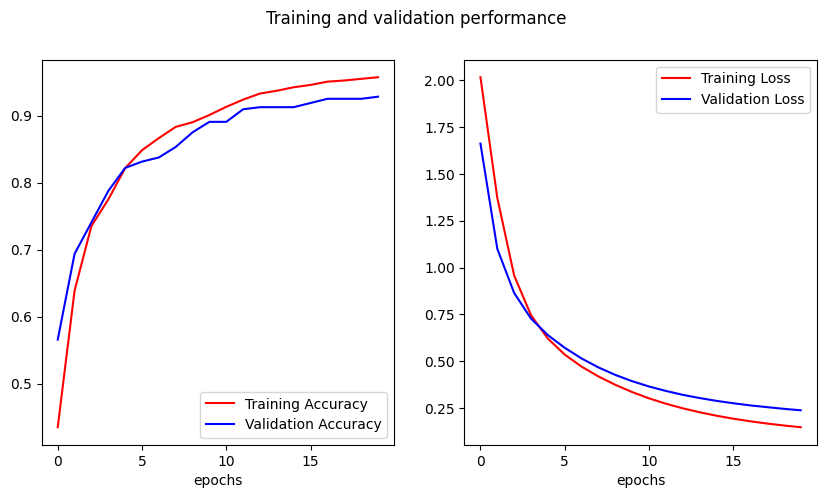

In [222]:
# Get training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation performance')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')